# [Moduel 3.1] 뉴럴 토픽 모델링 (Neural Topic Modeling)

이 노트북은 아래의 공식 블로그 및 샘플 노트북의 내용을 참조하여 작성 하였습니다. NTM의 기술적인 부분들은 아래를 참조 해주세요.
아래 참조는 20Newsgroups 영문 데이터를 사용 합니다. <br>
**이 노트북은 아마존 리뷰의 영문을 한글로 번역하여, 한글을 입력으로 사용합니다.** 이에 따른 한글 Tokenizer, 한글 전처리, 한글 폰트를 추가적으로 넣었습니다.

- An Introduction to SageMaker Neural Topic Model
    - Blog: https://aws.amazon.com/ko/blogs/machine-learning/introduction-to-the-amazon-sagemaker-neural-topic-model/
    - Notebook: https://github.com/aws/amazon-sagemaker-examples/blob/master/introduction_to_applying_machine_learning/ntm_20newsgroups_topic_modeling/ntm_20newsgroups_topic_model.ipynb
    
## 노트북 컨텐츠 (약 20분 소요)
- 데이터 준비
    - 아마존닷컴의 Grocery에 해당하는 부정 리뷰 데이터 셋 로딩
    - 각 리뷰에 대해서 Counter Vector 만들기
    - Vocabulary 파일을 만들어, 훈련시 보조 데이터로 활용
    - 데이터를 훈련, 검증, 테스트로 분리
    - 훈련, 검증 데이터, Vocabulary 파일을 RecordIO Protobuf 포맷으로 변경하여 S3 업로드
- 모델 훈련
    - 토픽 수 지정 
- 모델 호스팅 및 추론
- 모델 탐색 및 워드 클라우드 생성
    - 훈련된 모델 다운로드 및 모델 파라미터 로딩
    - 워드 클라우드 생성
- **워드 클라우드 분석, 토픽 정의 및 예시**
    - 3개 토픽에 대한 Top 10 단어 기술
    - 3개 토픽에 대한 정의를 기술
    - 토픽 별 예시 리뷰 확인
- 모델 호스팅 엔드포인트 삭제

## NTM 아키텍쳐 요약 (Option)
- 입력으로써 단어의 갯수에 대한 **높은 차원의 벡터들**을 입력으로 사용합니다. 아래 그림에서 x 로 기술 되었습니다. (아래 노트북에서 자세한 사항은 Counter Vector 부분을 참고 하세요.)
    - 만약 Vocabulary(단어집)이 1000개로 되어 있으면, x의 개수는 1000개 입니다.
- x 는 **낮은 차원의 벡터들** 인 z 의 값으로 변환 됩니다. 
    - 토픽수를 3을 지정하면 z는 3개 입니다.
    - 즉 x (1000개) --> z (3개) 로 압축이 됩니다.
- z 는 다시 W(가중치) 를 사용하여 x 로 변환 됩니다.
    - 즉 z (3개) --> x (1000개) 로 변환 됩니다.
    - **W는 이 경우에 1000 * 3 의 행렬의 형태 입니다.** 각각의 토픽에 대해서 토픽 영향을 주는 1000개의 단어에 대한 가중치 데이터 입니다.
    - W는 추후 아래에서 워드 클라우드를 만드는데 사용 됩니다.
- 네트워크는 x --> z --> x 의 복원에 대한 에러를 줄이고, 오버피팅(과대 적합)을 막기 위해서 h 를 가우시안 정규 분포 (평균 0, 표준편차 1)와 같게 만들기 위해서 훈련을 합니다. 훈련을 통해서 필요한 모델 파라미터(예: W)를 최적화 시키게 됩니다.

좀 더 상세 사항은 위 노트북의 블로그를 참조 하세요.

![3.ntm-arch](img/3.ntm-arch.png)

## 필요한 패키지 설치

아래는 주석 표시가 되어 있습니다. 처음 실행시에 주석을 풀어주시고 실행 해주세요.

In [1]:
# update sagemake package, in order to use write_spmatrix_to_sparse_tensor in the next cell
!pip install -U sagemaker
!pip install konlpy # 한글 Tokenizer 사용
!pip install wordcloud

     |████████████████████████████████| 310 kB 1.1 MB/s eta 0:00:01
  Created wheel for sagemaker: filename=sagemaker-2.15.0-py2.py3-none-any.whl size=433528 sha256=950e00b7f6aa649db67964ff99efc02fdeb38a5bc3333e61c3a98e3ef939d14d
  Stored in directory: /home/ec2-user/.cache/pip/wheels/b5/af/5b/dd429efe1e5c3e5e54340ec49407c59ffe0a6bbdfde21ceb4b
Successfully built sagemaker
  Attempting uninstall: sagemaker
    Found existing installation: sagemaker 2.14.0
    Uninstalling sagemaker-2.14.0:
      Successfully uninstalled sagemaker-2.14.0
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/mxnet_p36/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/mxnet_p36/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/mxnet_p36/bin/python -m pip install --upgrade pip' command.


In [2]:
from IPython.display import display
import pandas as pd

## 데이터 세트 로딩

In [3]:
# 기존 노트북에서 생성된 데이터 로딩
%store -r grocery_negative_path 

In [4]:
import csv
pd.options.display.max_colwidth = 1000

df = pd.read_csv(grocery_negative_path,
                 encoding='utf-8',engine='python')
print("data shape: ", df.shape)

data = df['review_body_kr_cl'].tolist() # 이 컬럼만 사용합니다.

data shape:  (14458, 4)


## 샘플 데이터 보기

In [5]:
data[0:5], len(data)

(['멋진 진저 맥주 지금까지 내가 제일 좋아하는 나는 매우 적시에 발송물을 받았지만 모든 외부 캔은 분쇄되어 플라스틱 안에 분사되었습니다 나는 소다 선적을위한 더 나은 내부 포장을 기대했다 적어도 소다와 상자 사이의 장벽 내 음료의 절반 이상이 패키지에 쏟아졌다 ',
  '리스의 부활절 에그 는 초콜릿과 땅콩 버터의 녹은 풀로 도착했습니다 난 열지도 않았어썩은 운송 방법이 이 보물을 죽였는데 이 보물이 제 아이들의 부활절 일요일을 밝히기 전에 말입니다 어찌됐어 크리스 트레이너 뉴저지 주 ',
  '밀가루 자체는 매우 좋습니다 내가 좋아하지 않는 것은 최고 날짜가 개월 만에 있다는 것입니다 개월 만에 밀가루 봉지 우리 가정에서는 아니야그보다 더 긴 유통 기한이 있어야합니다 ',
  '한 번 진짜 코코넛으로 만든 좋은 제품 지금 농축에서 물로 희석 이 따뜻한 마실 수 있기 전에 여전히 좋은 맛 더 이상 안돼 원 구매',
  '나는 제품의 배달과 제품 자체에 실망했다 나는 그것을 추천 할 수 없다 제품이 녹은 플라스틱 얼음 팩으로 둘러싸여 도착했습니다 제품이 실온에서 상자에서 나오고 운송 중 높은 주변 온도를 통과했을 수 있습니다 제품을 사용하려고 할 때 거의 보이지 않는 내부 플라스틱 슬리브가 있음을 발견했습니다 그 결과 나는 실수로 신선한 김이 나는 파스타 한 접시 위에 제품과 플라스틱 슬리브의 일부를 강판했다 플라스틱 조각을 발견했을 때 파스타를 버려야했습니다 마지막으로 제품 표면에서 내부 플라스틱 슬리브를 떼어 낸 후 나는 신선한 생선보다 통조림 고양이 사료에 더 연상시키는 제품에서 나오는 냄새를 감지했습니다 건강에 좋지 않은 결과없이 소량의 제품을 샘플링했지만 말린 생선 알보다 압축 된 소금처럼 맛이 더 좋다고 결론을 내렸습니다 나는 남아있는 것을 버렸다 '],
 14458)

## Counter Vector 생성

Counter Vector는 주어진 문장들 (아래는 5개의 문장)에서 중복없이 단어들을 추출하여 Vocabulary(단어집)을 만들고 (아래는 7개의 단어로 단어집 구성), 그리고 각 문장에서 해당 단어가 몇 번 발생하는지를 기록하여 만듭니다. NLP 용어로 Bag-of-Words (BOW) 라고 합니다. Counter vector는 NTM 알고리즘에 입력 데이터로 사용 됩니다.
```
# 테스트 문장
rawdata = [
    '남북 고위급회담 대표단 확정..남북 해빙모드 급물살',
    '[남북 고위급 회담]장차관만 6명..판 커지는 올림픽 회담',
    
    '문재인 대통령과 대통령의 영부인 김정숙여사 내외의 동반 1987 관람 후 인터뷰',
    '1987 본 문 대통령.."그런다고 바뀌나? 함께 하면 바뀐다"',
    
    '이명박 전 대통령과 전 대통령의 부인 김윤옥 여사, 그리고 전 대통령의 아들 이시형씨의 동반 검찰출석이 기대됨'
]
```
```
# Counter Vector
	1987 고위 남북  대통령  동반  여사  회담
0	0	1	2	0	0	0	1
1	0	1	1	0	0	0	2
2	1	0	0	2	1	1	0
3	1	0	0	1	0	0	0
4	0	0	0	3	1	1	0
```


##### [참조] sklearn / 문장 특징 추출과 유사도 측정
    - https://blog.breezymind.com/2018/03/02/sklearn-feature_extraction-text-2/

#### KoNLPy 패키지의 Tokenizer 사용
명사, 동사, 형용사, 부사, 알파벳을 사용함.

In [6]:
from sklearn.feature_extraction.text import CountVectorizer

import numpy as np
np.random.seed(0)
 
from konlpy.tag import Twitter
twitter = Twitter()
 
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
 
# tokenizer : 문장에서 색인어 추출을 위해 명사,동사,형용사, 부사, 알파벳 정도의 단어만 뽑아서 normalization, stemming 처리하도록 함
def tokenizer(raw, pos=["Noun","Alpha","Verb","Adjective", "Adverb"], stopword=[]):
    return [
        word for word, tag in twitter.pos(
            raw, 
            norm=True,   # normalize 그랰ㅋㅋ -> 그래ㅋㅋ
            stem=True    # stemming 바뀌나->바뀌다
            )
            if len(word) > 1 and tag in pos and word not in stopword
        ]

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/konlpy/tag/_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


In [7]:
%%time 

vocab_size = 1000 # vocab size를 1000로 설정
vectorize = CountVectorizer(
    tokenizer=tokenizer, 
    min_df = 2,
    max_df = 0.8,
                # 예제로 보기 좋게 1번 정도만 노출되는 단어들은 무시하기로 했다
                # min_df = 0.01 : 문서의 1% 미만으로 나타나는 단어 무시
                # min_df = 10 : 문서에 10개 미만으로 나타나는 단어 무시
                # max_df = 0.80 : 문서의 80% 이상에 나타나는 단어 무시
                # max_df = 10 : 10개 이상의 문서에 나타나는 단어 무시
    max_features = vocab_size
)
 
# 문장에서 노출되는 feature(특징이 될만한 단어) 수를 합한 Counter Vectors 을 리턴한다
X = vectorize.fit_transform(data)
 
print(
    'fit_transform, (sentence {}, feature {})'.format(X.shape[0], X.shape[1])
)
  
print(X.toarray())
vectors = X


fit_transform, (sentence 14458, feature 1000)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
CPU times: user 3min 8s, sys: 1.44 s, total: 3min 10s
Wall time: 2min 34s


In [8]:
print(type(vectors), vectors.dtype)
print("The vector example: ", vectors[0])

<class 'scipy.sparse.csr.csr_matrix'> int64
The vector example:    (0, 329)	1
  (0, 321)	1
  (0, 826)	1
  (0, 807)	1
  (0, 318)	1
  (0, 766)	1
  (0, 387)	1
  (0, 336)	1
  (0, 678)	1
  (0, 442)	1
  (0, 254)	2
  (0, 945)	1
  (0, 506)	1
  (0, 160)	1
  (0, 175)	1
  (0, 936)	1
  (0, 135)	1
  (0, 767)	1
  (0, 655)	1
  (0, 487)	1
  (0, 477)	1
  (0, 704)	1
  (0, 775)	1
  (0, 719)	1
  (0, 926)	1


## Vocabuary(단어집) 예시 확인
위에서 단어집의 사이즈를 1000으로 했습니다. 마지막 10개를 예시로써 보여줍니다.

In [9]:
vocab_list = vectorize.get_feature_names()
print('vocab size:', len(vocab_list))
vocab_list[990:]

vocab size: 1000


['후추', '훌륭하다', '훨씬', '흔들다', '흥분하다', '희다', '희망', '흰색', '힌트', '힘들다']

## Vocabulary 파일 준비

vocab.txt 파일을 준비하여, 훈련시에 입력으로 제공 합니다. 훈련의 로그의 마지막에서 토픽에 가장 관련이 있는 단어들을 보여줄 때에, 단어의 숫자로 보여주지 않고, 숫자와 매핑이 된 글자로 보여줍니다.

아래는 훈련시 토픽의 수를 3으로 하고, 훈련 마지막의 로그를 가져왔습니다. 훈련시이 로그나 CloudWatch에서 볼수 있습니다. <br>
각 토픽의 결정에 영향을 가장 많이 주는 단어들을 보여 주고 있습니다. <br>
**아래의 결과와 실제 실행 결과는 모델 훈련시 마다 초기값 달라지기 때문에 결과는 조금씩 달라집니다.**
```
[10/10/2020 04:01:16 INFO 139804456290112] Topics from epoch:final (num_topics:3) [wetc 0.90, tu 0.95]:
[10/10/2020 04:01:16 INFO 139804456290112] [0.90, 0.93] keurig 열리다 호환 손상 만료 깨지다 밀봉 날짜 상자 녹다 도착 개별 절반 봉투 추다 부서지다 소지 분쇄 기계 제대로
[10/10/2020 04:01:16 INFO 139804456290112] [0.91, 1.00] 가격 달러 월마트 지불 상점 비싸다 온스 비용 금액 식료품 거래 지역 저렴하다 대한 가게 가치 크기 파운드 여기 costco
[10/10/2020 04:01:16 INFO 139804456290112] [0.90, 0.93] 로스트 keurig 네스프레소 양조 메이커 찌꺼기 커피 포드 호환 기계 약하다 벅스 작동 캡슐 에스프레소 두운 카페인 필터 인스턴트 프랑스
```
아래는 관련된 블로그 입니다. 상세한 사항은 아래를 참고 하세요.
- Amazon SageMaker Neural Topic Model now supports auxiliary vocabulary channel, new topic evaluation metrics, and training subsampling
    - https://aws.amazon.com/ko/blogs/machine-learning/amazon-sagemaker-neural-topic-model-now-supports-auxiliary-vocabulary-channel-new-topic-evaluation-metrics-and-training-subsampling/

In [10]:
import os
aux_data_dir = 'preproc_data/amazon_review/auxiliary'
os.makedirs(aux_data_dir, exist_ok=True)
with open(os.path.join(aux_data_dir, 'vocab.txt'), 'w', encoding='utf-8') as f:
    for item in vocab_list:
        f.write(item+'\n')

In [11]:
import sagemaker
from utils import upload_s3
import os

bucket = sagemaker.Session().default_bucket()
prefix = 'ml-architect/topic'

aux_path = os.path.join(aux_data_dir, 'vocab.txt')

s3_aux_data = upload_s3(bucket, aux_path, prefix)
print("s3_aux_data: ", s3_aux_data)

s3_aux_data:  s3://sagemaker-ap-northeast-2-057716757052/ml-architect/topic/preproc_data/amazon_review/auxiliary/vocab.txt


## 데이터 세트 분리 (훈련, 검증, 테스트)
NTM 모델 파라미터의 변수 타입은 np.float32를 사용합니다. 그래서 sparse 매트릭스에서 타입을 np.float32로 변경 합니다.

In [12]:
import scipy.sparse as sparse
vectors = sparse.csr_matrix(vectors, dtype=np.float32)
print(type(vectors), vectors.dtype)

<class 'scipy.sparse.csr.csr_matrix'> float32


데이터를 80%, 10%, 10%로 훈련, 검증, 테스트 데이터 세트로 변경 합니다.

In [13]:
n_train = int(0.8 * vectors.shape[0])

# split train and test
train_vectors = vectors[:n_train, :]
test_vectors = vectors[n_train:, :]

# further split test set into validation set (val_vectors) and test  set (test_vectors)
n_test = test_vectors.shape[0]
val_vectors = test_vectors[:n_test//2, :]
test_vectors = test_vectors[n_test//2:, :]

In [14]:
print(train_vectors.shape, test_vectors.shape, val_vectors.shape)

(11566, 1000) (1446, 1000) (1446, 1000)


### 훈련 및 검증 데이터 세트를 RecordIO Protobuf 포맷 변경하여 S3 업로드



S3로 업로드하기 위해서 훈련, 검증, 단어집의 S3 경로를 지정 합니다.

In [15]:
import os
import sagemaker
from sagemaker import get_execution_role

role = get_execution_role()

sess = sagemaker.Session()
bucket=sess.default_bucket()

prefix = 'ml-architect/ntm/amazon-review'

train_prefix = os.path.join(prefix, 'train')
val_prefix = os.path.join(prefix, 'val')

output_prefix = os.path.join(prefix, 'output')
s3_train_data = os.path.join('s3://', bucket, train_prefix)
s3_val_data = os.path.join('s3://', bucket, val_prefix)

output_path = os.path.join('s3://', bucket, output_prefix)
print('Training set location', s3_train_data)
print('Validation set location', s3_val_data)
print('Trained model will be saved at', output_path)

Training set location s3://sagemaker-ap-northeast-2-057716757052/ml-architect/ntm/amazon-review/train
Validation set location s3://sagemaker-ap-northeast-2-057716757052/ml-architect/ntm/amazon-review/val
Trained model will be saved at s3://sagemaker-ap-northeast-2-057716757052/ml-architect/ntm/amazon-review/output


아래에서는 RecordIO Protobuf로 포맷을 변경 하여 S3에 업로드 합니다. 
또한 업로드 하기 전에 전체 사이즈를 특정 개수로 분리합니다. (n_parts 변수 사용). <br>
현재 NTM 알고리즘은 복수개의 훈련 파일을 지원하고 있으며, 이렇게 분리하면 분산 학습시에 각 파일들이 분산되어 분산 훈련에 더욱 좋은 성능을 나타낼 수 있습니다.

In [16]:
def split_convert_upload(sparray, bucket, prefix, fname_template='data_part{}.pbr', n_parts=2):
    import io
    import boto3
    import sagemaker.amazon.common as smac
    
    chunk_size = sparray.shape[0]// n_parts
    for i in range(n_parts):

        # Calculate start and end indices
        start = i*chunk_size
        end = (i+1)*chunk_size
        if i+1 == n_parts:
            end = sparray.shape[0]
        
        # Convert to record protobuf
        buf = io.BytesIO()
        smac.write_spmatrix_to_sparse_tensor(array=sparray[start:end], file=buf, labels=None)
        buf.seek(0)
        
        # Upload to s3 location specified by bucket and prefix
        fname = os.path.join(prefix, fname_template.format(i))
        boto3.resource('s3').Bucket(bucket).Object(fname).upload_fileobj(buf)
        print('Uploaded data to s3://{}'.format(os.path.join(bucket, fname)))

In [17]:
split_convert_upload(train_vectors, bucket=bucket, prefix=train_prefix, fname_template='train_part{}.pbr', n_parts=8)
split_convert_upload(val_vectors, bucket=bucket, prefix=val_prefix, fname_template='val_part{}.pbr', n_parts=1)

Uploaded data to s3://sagemaker-ap-northeast-2-057716757052/ml-architect/ntm/amazon-review/train/train_part0.pbr
Uploaded data to s3://sagemaker-ap-northeast-2-057716757052/ml-architect/ntm/amazon-review/train/train_part1.pbr
Uploaded data to s3://sagemaker-ap-northeast-2-057716757052/ml-architect/ntm/amazon-review/train/train_part2.pbr
Uploaded data to s3://sagemaker-ap-northeast-2-057716757052/ml-architect/ntm/amazon-review/train/train_part3.pbr
Uploaded data to s3://sagemaker-ap-northeast-2-057716757052/ml-architect/ntm/amazon-review/train/train_part4.pbr
Uploaded data to s3://sagemaker-ap-northeast-2-057716757052/ml-architect/ntm/amazon-review/train/train_part5.pbr
Uploaded data to s3://sagemaker-ap-northeast-2-057716757052/ml-architect/ntm/amazon-review/train/train_part6.pbr
Uploaded data to s3://sagemaker-ap-northeast-2-057716757052/ml-architect/ntm/amazon-review/train/train_part7.pbr
Uploaded data to s3://sagemaker-ap-northeast-2-057716757052/ml-architect/ntm/amazon-review/val/v

---
# 모델 훈련

- SageMaker의 내장 알고리즘인 NTM을 가져와서 학습을 하고, 여기서는 인스턴스 2개 및 ml.c5.9xlarge를 사용합니다
- 데이터가 적기에 CPU를 사용하였고, 데이터가 많으면 GPU를 사용하시기를 바랍니다.
- 아래 소요시간은 약 5분 걸립니다.

In [18]:
from sagemaker import image_uris, session
container = image_uris.retrieve("ntm", session.Session().boto_region_name, version="latest")

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: latest.


In [19]:
import sagemaker
sess = sagemaker.Session()
ntm = sagemaker.estimator.Estimator(container,
                                    role, 
                                    instance_count= 2, 
                                    instance_type='ml.c5.9xlarge',
                                    output_path=output_path,
                                    sagemaker_session=sess)

## 파리미터 설정 ([중요] 토픽 개수 지정)
- **훈련이 되는 텍스트의 성질에 따라서 토픽의 수 결정이 중요 합니다.**
- 토픽의 수에 따라서 아래 TU의 지표가 달라집니다. 현재의 데이타로 토픽 5로 할 경우에는 TU 값이 3으로 할 경우 보다 낮습니다.

#### TU (Topic Uniqueness)
- TU는 토픽이 각각 얼마나 유니크한지를 나타내는 지표 입니다. TU는 1/토픽수(K) 부터 1 사이에 위치 합니다. 높을 수록 유니크 하다는 것을 나타냅니다.
- TU의 계산 방법은 토픽에 가장 영향을 많이 주는 Top N 단어들에 대해서, 다른 토픽의 Top N 단어들에 얼마나 중복이 되는지를 체크 합니다. 
    - 예를 들어 아래 토픽2 번째의 단어들 "가격 달러 월마트 지불 상점 비싸다 온스 비용 금액 식료품 거래 지역 저렴하다 대한 가게 가치 크기 파운드 여기 costco" 은 다른 토픽1, 토픽2 에 중복으로 있지 않습니다. 그래서 ```[0.91, 1.00]``` 1.00의 값을 보여주고 있습니다.
    - 아래 토픽1, 토픽2 에서는 Keurig(커피 머신 브랜드)가, 토픽1, 토픽2에 중복으로 있기에 0.93 수치를 보여주고 있습니다.
- 3개 토픽 ```[wetc 0.90, tu 0.95]``` 에 대해서는 각 토픽의 TU를 평균을 낸 (0.93 + 1.00 + 0.93) / 3 을 하여 0.95가 나옵니다.
    - 참고로 wetc (Word Embedding Topic Coherence)로서 토픽별로 Top N 단어들이 얼마나 유사성이 있는지를 알려 주는 지표 입니다. 이 수치는 pre-trained word embedding (Glove-6B-400K-50d) 를 이용하여 유사도를 구하는데요, 영어로 되어 있기에 올바른 wetc가 나오지 않습니다. 그래서 이 수치는 무시하시기를 바랍니다.
        - 실제적으로 훈련시 로그에 다음과 같이 있습니다. ```139804456290112] 992 out of 1000 in vocabulary do not have embeddings! Default vector used for unknown embedding!```
- TU는 제공한 단어집(여기서는 1000개)에 있는 어휘에 상관 없이, 훈련에 주어진 모든 텍스트에 대해서 수행 합니다.

**아래의 결과와 실제 실행 결과는 모델 훈련시 마다 초기값 달라지기 때문에 결과는 조금씩 달라집니다.**
```
[10/10/2020 04:01:16 INFO 139804456290112] Topics from epoch:final (num_topics:3) [wetc 0.90, tu 0.95]:
[10/10/2020 04:01:16 INFO 139804456290112] [0.90, 0.93] keurig 열리다 호환 손상 만료 깨지다 밀봉 날짜 상자 녹다 도착 개별 절반 봉투 추다 부서지다 소지 분쇄 기계 제대로
[10/10/2020 04:01:16 INFO 139804456290112] [0.91, 1.00] 가격 달러 월마트 지불 상점 비싸다 온스 비용 금액 식료품 거래 지역 저렴하다 대한 가게 가치 크기 파운드 여기 costco
[10/10/2020 04:01:16 INFO 139804456290112] [0.90, 0.93] 로스트 keurig 네스프레소 양조 메이커 찌꺼기 커피 포드 호환 기계 약하다 벅스 작동 캡슐 에스프레소 두운 카페인 필터 인스턴트 프랑스
```


In [20]:
###################
num_topics = 3
# num_topics = 5
###################
ntm.set_hyperparameters(num_topics=num_topics, feature_dim=vocab_size, mini_batch_size=32, 
                        epochs=100, num_patience_epochs=5, tolerance=0.001)

In [21]:
from sagemaker.inputs import TrainingInput

s3_train = TrainingInput(s3_train_data, distribution='ShardedByS3Key') 
s3_val = TrainingInput(s3_val_data, distribution='FullyReplicated')
s3_aux = TrainingInput(s3_aux_data, distribution='FullyReplicated')

In [22]:
%%time
ntm.fit({'train': s3_train, 'validation': s3_val_data, 'auxiliary': s3_aux})

2020-10-10 09:39:39 Starting - Starting the training job...
2020-10-10 09:39:42 Starting - Launching requested ML instances...
2020-10-10 09:40:40 Starting - Preparing the instances for training......
2020-10-10 09:41:27 Downloading - Downloading input data
2020-10-10 09:41:27 Training - Downloading the training image..Docker entrypoint called with argument(s): train
Running default environment configuration script
/opt/amazon/lib/python2.7/site-packages/pandas/util/nosetester.py:13: DeprecationWarning: Importing from numpy.testing.nosetester is deprecated, import from numpy.testing instead.
  from numpy.testing import nosetester
[10/10/2020 09:41:55 INFO 139854603712320] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'num_patience_epochs': u'3', u'clip_gradient': u'Inf', u'encoder_layers': u'auto', u'optimizer': u'adadelta', u'_kvstore': u'auto_gpu', u'rescale_gradient': u'1.0', u'_tuning_objective_metric': u'', u'_num_gpus':

In [23]:
print('Training job name: {}'.format(ntm.latest_training_job.job_name))

Training job name: ntm-2020-10-10-09-39-39-609


# 모델 호스팅 및 추론 
- 모델 호스팅을 위해서 엔드포인트를 생성 합니다. 생성 시간은 약 7분 걸립니다.

In [24]:
%%time
ntm_predictor = ntm.deploy(initial_instance_count=1, instance_type='ml.m4.2xlarge')

-------------!CPU times: user 389 ms, sys: 101 ms, total: 491 ms
Wall time: 6min 31s


In [25]:
print('Endpoint name: {}'.format(ntm_predictor.endpoint_name))

Endpoint name: ntm-2020-10-10-09-43-22-279


---
## Data Serialization/Deserialization

- 입력으로서 CSV 형태로 데이터를 제공하기에, ```CSVSerializer()```이 필요합니다.
- 출력으로서 Json 형태로 받기에 ```JSONDeserializer()```이 필요 합니다.


### Inference with CSV

In [26]:
from sagemaker.deserializers import JSONDeserializer
from sagemaker.serializers import CSVSerializer

# ntm_predictor.content_type = 'text/csv'
ntm_predictor.serializer = CSVSerializer()
ntm_predictor.deserializer = JSONDeserializer()

### 테스트 데이터로 추론 및 가시화
- 위에서 만든 테스트 데이터 셋트 중에 5개를 추론 해보겠습니다.
- 각각의 샘플은 아래와 같은 추론 결과를 받습니다. 각각의 토픽에 할당될 가중치를 제공 받습니다.
- 아래 추론 결과를 막대 차트로 가시화하여, 쉽게 어느 토픽에 높은 가중치를 받는지를 확인할 수 있습니다.

**아래의 결과와 실제 실행 결과는 모델 훈련시 마다 초기값 달라지기 때문에 결과는 조금씩 달라집니다.**
```
{'predictions': [{'topic_weights': [0.7756354809, 0.1030569598, 0.121307537]}, 
                 {'topic_weights': [0.5923846364, 0.1434145421, 0.2642008662]}, 
                 {'topic_weights': [0.4249233902, 0.410485208, 0.1645913571]}, 
                 {'topic_weights': [0.2991273403, 0.4799318612, 0.2209408134]}, 
                 {'topic_weights': [0.2675780654, 0.3378966153, 0.3945253193]}]}
```




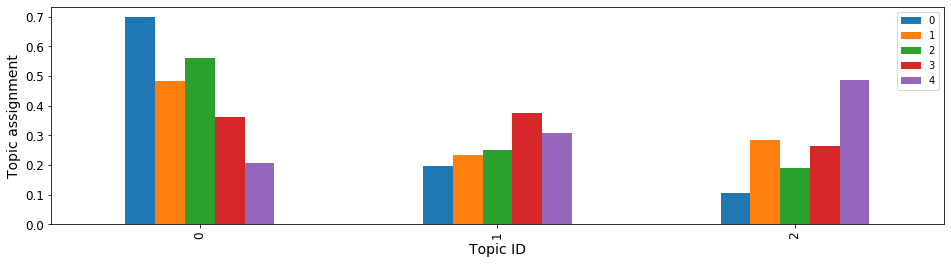

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

def infer_topic(test_data, predictor, num_inference):
    results = predictor.predict(test_data[:num_inference])
    # print(results)

    predictions = np.array([prediction['topic_weights'] for prediction in results['predictions']])

    fs = 12
    df=pd.DataFrame(predictions.T)
    df.plot(kind='bar', figsize=(16,4), fontsize=fs)
    plt.ylabel('Topic assignment', fontsize=fs+2)
    plt.xlabel('Topic ID', fontsize=fs+2)
    
    
test_data = np.array(test_vectors.todense())    
infer_topic(test_data, ntm_predictor, num_inference = 5)    

---
Now we can take a look at how the 20 topics are assigned to the 5 test documents with a bar plot.

# 모델 탐색 및 워드 클라우드 만들기

토픽에 영향을 가장 많이 주는 Top N 단어들을 워드 클라우드로 만들어 보면, 어느 단어가 영향을 많이 주는지 쉽게 알 수 있습니다. 이를 위해 아래와 같은 작업을 합니다.
- 훈련된 학습 모델을 다운로드 받아서 모델 파라미터 파일을 로딩 합니다.
- 모델 파라미터 파일에서 "arg:projection_weight" 이름의 가중치 (토픽당 단어집 수, 여기서는 1000개)를 가져 옵니다.
    - 이 노트북의 맨 상단의 네트워크 아키텍쳐 그림에서 W를 의미 합니다.
    - W의 shape은 1000 * 3 입니다. (3은 토픽수, 1000은 단어집수)
- 토픽당 1000개의 가중치를 Softmax로 Normalize 하여 표준화된 가중치를 생성 합니다.
- 단어집의 단어와 표준화된 가중치를 매핑하여 아래와 같이 사전을 생성합니다.
```
{'amazon': 0.0008921864, 'com': 0.0006217166, 'costco': 0.00075492694, 'gmo': 0.0004100625, 'keurig': 0.008611561, 'lb': 0.0021297277, 'mg': 0.00091790303, 'msg': 0.000604335, '가게': 0.00080568675, '가격': 0.0010566652, '가공': 0.0005775973, '가깝다': 0.0006391816, '가난하다': 0.0005827846, '가능하다': 0.0011932052, '가다': 0.001125062, '가득': 0.0009464648 ......}
```
- 위의 사전을 워드 클라우드로 생성 합니다.
    - 사전에 한글 폰트를 다운로드 받았습니다. 이를 통해서 한글을 보이게 합니다.
- **워드 클라우드의 단어의 크기가 영향을 주는 가중치와 비례 합니다. 즉 단어의 크기가 클수록 토픽 결정에 영향을 많이 주는 단어 입니다.**


### 모델 다운로드 및 파라미터 로딩

In [28]:
# If you use conda_mxnet_p36 kernel, mxnet is already installed, otherwise, uncomment the following line to install.
# !pip install mxnet 
import boto3
import mxnet as mx

model_path = os.path.join(output_prefix, ntm._current_job_name, 'output/model.tar.gz')
print("model_path: ", model_path)
s3_model_path = f's3://{bucket}/{model_path}'
print("s3_model_path: ", s3_model_path)

model_path:  ml-architect/ntm/amazon-review/output/ntm-2020-10-10-09-39-39-609/output/model.tar.gz
s3_model_path:  s3://sagemaker-ap-northeast-2-057716757052/ml-architect/ntm/amazon-review/output/ntm-2020-10-10-09-39-39-609/output/model.tar.gz


In [29]:
import tarfile
import sagemaker
from utils import download_extact_infer_file

output_model_folder = 'model'
os.makedirs(output_model_folder, exist_ok=True)
file_name = 'model.tar.gz'
download_extact_infer_file(s3_model_path, output_model_folder, file_name)
!unzip -o {output_model_folder}/model_algo-1 -d {output_model_folder}

Infer file model/model.tar.gz is downloaded
Infer file model/model.tar.gz is extracted
Archive:  model/model_algo-1
 extracting: model/meta.json         
 extracting: model/symbol.json       
 extracting: model/params            


We can load the model parameters and extract the weight matrix $W$ in the decoder as follows

In [30]:
model = mx.ndarray.load(f'{output_model_folder}/params')
W = model['arg:projection_weight']

In [31]:
W.shape

(1000, 3)

## 워드 클라우드 생성

Topic 0 - top 10 influential words: 
 {4: 'keurig', 302: '만료', 648: '열리다', 487: '상자', 145: '깨지다', 668: '온스', 521: '손상', 164: '날짜', 244: '도착', 775: '절반'}
Topic 1 - top 10 influential words: 
 {4: 'keurig', 458: '비싸다', 831: '지불', 43: '개월', 164: '날짜', 686: '우편', 911: '튀어', 775: '절반', 935: '포드', 9: '가격'}
Topic 2 - top 10 influential words: 
 {4: 'keurig', 288: '로스트', 889: '커피', 614: '양조', 330: '메이커', 757: '작동', 186: '네스프레소', 612: '약하다', 131: '기계', 935: '포드'}


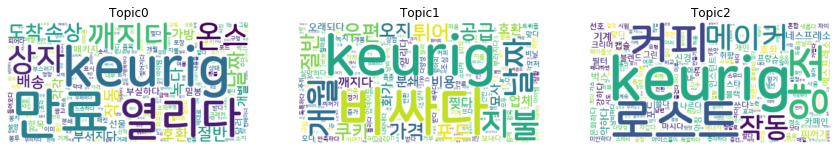

In [32]:
import wordcloud as wc

word_to_id = dict()
for i, v in enumerate(vocab_list):
    word_to_id[v] = i

limit = 24
n_col = 4
counter = 0
topk = 10

plt.figure(figsize=(20,16))
top_vocab_list = list()
for ind in range(num_topics):

    if counter >= limit:
        break

    title_str = 'Topic{}'.format(ind)

    pvals = mx.nd.softmax(mx.nd.array(W[:, ind])).asnumpy()
    # print("pvals: \n", pvals)
    pvals_m = mx.nd.softmax(W[:, ind])    

    topk_pred = pvals.argsort()[-topk:][::-1].astype(int)    
    print(f"Topic {ind} - top {topk} influential words: \n",  {i: vocab_list[i] for i in topk_pred})    
    top_vocab_list.append({i: vocab_list[i] for i in topk_pred})
    # print("top k prediction vocab prob. values: \n", pvals[topk_pred])


    word_freq = dict()

    for k in word_to_id.keys():
        i = word_to_id[k]
        word_freq[k] =pvals[i]

    # print(word_freq)        
    font_path = 'data/font/NanumSquareRoundB.ttf'
    wordcloud = wc.WordCloud(background_color='white',font_path = font_path).fit_words(word_freq)

    plt.subplot(limit // n_col, n_col, counter+1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title_str)
    counter +=1
    

    

# 워드 클라우드 분석, 토픽 정의 및 예시
**아래의 결과와 위의 실행 결과는 모델 훈련시 마다 초기값이 달라지기 때문에 결과는 조금씩 달라집니다.**

## 토픽 3개에 대한 워드 클라우드 
**글자 크기가 토픽 결정에 영향도를 나타냅니다.**

![0.az-groc-3](img/0.az-groc-3.png)

#### 아래는 위 워드클라우드의 속한 단어를 영향을 많이 주는 순으로 보여 줍니다.
```
Topic 0 - top 10 influential words: 
 {4: 'keurig', 648: '열리다', 977: '호환', 521: '손상', 302: '만료', 145: '깨지다', 366: '밀봉', 164: '날짜', 487: '상자', 189: '녹다'}
Topic 1 - top 10 influential words: 
 {9: '가격', 222: '달러', 691: '월마트', 831: '지불', 488: '상점', 458: '비싸다', 668: '온스', 459: '비용', 128: '금액', 553: '식료품'}
Topic 2 - top 10 influential words: 
 {288: '로스트', 4: 'keurig', 186: '네스프레소', 614: '양조', 330: '메이커', 845: '찌꺼기', 889: '커피', 935: '포드', 977: '호환', 131: '기계'}```
```
## 토픽 정의
#### 토픽0
- 상품 배송 이슈 및 유통 기한의  ("열리다", "깨지다", "녹다", "손상", "밀봉", "만료")

#### 토픽1
- 가격에 대한 내용 ("가격","달러","지불","비싸다","금액")

#### 토픽2
- 커피 및 차에 대한 내용 ("로스트","keurig","네스프레소","찌꺼기","커피")


## 토픽 할당 부정 리뷰 예시
예제로서 실제 토픽에 할당이 된 부정 리뷰를 토픽별로 보여 줍니다.

#### 토픽0
```
(1) 멋진 진저 맥주.지금까지, 내가 제일 좋아하는!나는 매우 적시에 발송물을 받았지만, 모든 외부 캔은 분쇄되어 플라스틱 안에 분사되었습니다.
나는 소다 선적을위한 더 나은 내부 포장을 기대했다.
적어도 소다와 상자 사이의 장벽.내 음료의 절반 이상이 패키지에 쏟아졌다.
(2) 7 월 1 주에 배달 된 제품. 5 월에 만료 된 2015
(3) 밀가루 자체는 매우 좋습니다.내가 좋아하지 않는 것은 “최고”날짜가 3 개월 만에 있다는 것입니다.
3 개월 만에 밀가루 4 봉지.우리 가정에서는 아니야그보다 더 긴 유통 기한이 있어야합니다.
```
#### 토픽1
```
(1) 정품이지만 너무 비쌉니다. $10 미만으로 코스트코 또는 Bj에서 얻을 수 있습니다.
(2) 이것을 위해 많이 보냈다... 일반 상점 구매 “싼”밀가루와이 “프리미엄”밀가루의 차이를 맛볼 수 없다... 아마도이 회사/판매자가 구매자를 사기꾼다.
(3) 나는 이번 여름 초에 많은 기대로이 라이치를 샀다.그러나 라이치스는 평범한 것보다 더 아무것도 없었다 
나는 로컬 일부 상점에서 더 나은 품질의 라이치를 얻을 것을 나중에 깨달았다.
이것에 돈을 낭비하는 데 실망감을 느낍니다.
```
#### 토픽2
```
(1) 그것은 맛이 없었기 때문에 정말 블루베리 녹차를 좋아하지 않았다.나는 그것을 맛을주기 위해 또 다른 차를 추가해야했다.
나는 정말로 그것을 다시 사지 않을 것이다.
(2) 컨테이너는 제품 가격에 비해 매우 작습니다.나는 망고 하나를 시도했고 나는 지금까지 그것을 좋아하지 않는다.
나쁜 뒷맛을 남기는 강한 냄새가 있습니다.나는 그것으로 아이스 티를 만들었고 일주일 넘게 지났고 끝나지 않았습니다: (내 돈 낭비!
(3) 잘 부어지지 않습니다.첫 번째 컵은 잘 갈 수 있지만 곧 쏟아지는 것은 물방울로 느려집니다.
카라 페 디자인은 끔찍합니다.커피를 뜨겁게 유지하는 것은 미덕이지만 카라페는 잘 부어 질 수 있어야합니다.
이것은 다른 사람들이 지적한대로 절대적으로 실패합니다.
```

## 훈련에 사용된 데이터의 토픽 분류 및 예시 리뷰

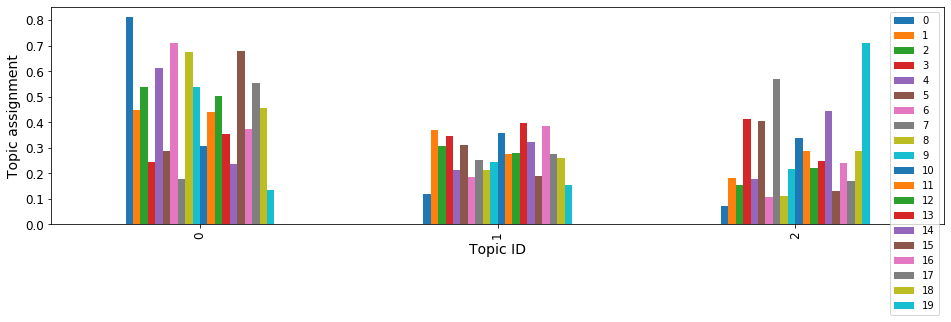

In [33]:
num_infererence = 20
train_data = np.array(train_vectors.todense())    
infer_topic(train_data, ntm_predictor, num_inference = num_infererence)    

In [34]:
df.review_body_kr.head(num_infererence)

0                                                                                                                                                                                                                                                                                                                                                                      멋진 진저 맥주.지금까지, 내가 제일 좋아하는!나는 매우 적시에 발송물을 받았지만, 모든 외부 캔은 분쇄되어 플라스틱 안에 분사되었습니다.나는 소다 선적을위한 더 나은 내부 포장을 기대했다.적어도 소다와 상자 사이의 장벽.내 음료의 절반 이상이 패키지에 쏟아졌다.
1                                                                                                                                                                                                                                                                                                                                                                                            리스의 “부활절 에그”는 초콜릿과 땅콩 버터의 녹은 풀로 도착했습니다.난 열지도 않았어썩은 운송 방법이 이 보물을 죽였는데, 이 보물이 제 아이들의 부활절 일요일을 밝히기 전에 말입니다.어찌됐어!크리스

## 엔드 포인트 제거
다 사용하셨으면 리소스 절약을 위해서 아래 주석을 열고 실행해 주세요

In [35]:
# sagemaker.Session().delete_endpoint(ntm_predictor.endpoint)